## Imports

In [7]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import  Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [8]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 

    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                # Ensure the image was read successfully
                if img_arr is None:
                    print(f"Skipping corrupted or non-readable image: {img_path}")
                    continue

                resized_arr = cv2.resize(img_arr, (img_size, img_size)) / 255.0  # Normalize
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img}: {e}")

    # np.random.shuffle(data)  # Shuffle data for better model training

    X = np.array([item[0] for item in data])  # Images
    y = np.array([item[1] for item in data])  # Labels

    return (X.reshape(-1, img_size, img_size, 1), y)  # Reshape for deep learning models

### Loading the data set

In [9]:
# Deze is van een week geleden ongeveer
train = get_training_data('Data/chest_xray/chest_xray/train')
test = get_training_data('Data/chest_xray/chest_xray/test')
val = get_training_data('Data/chest_xray/chest_xray/val')

Skipping corrupted or non-readable image: Data/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
Skipping corrupted or non-readable image: Data/chest_xray/chest_xray/train/NORMAL/.DS_Store
Skipping corrupted or non-readable image: Data/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
Skipping corrupted or non-readable image: Data/chest_xray/chest_xray/val/NORMAL/.DS_Store


### Data visualization & Preprocessing.

<Axes: xlabel='Condition', ylabel='count'>

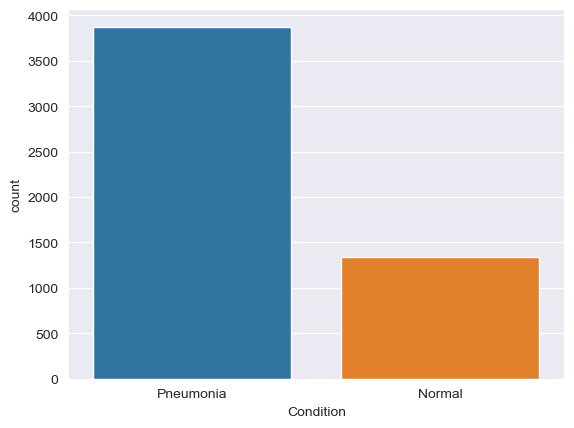

In [10]:
l = []
for i in train[1]: 
    if (i == 0):
        l.append("Pneumonia")
    else: 
        l.append("Normal")

sns.set_style('darkgrid')

#Converding the list into a dataframe so that countplot can accept it.
df = pd.DataFrame({"Condition": l})


sns.countplot(x="Condition", data=df)

### Previewing the images of both the classes.

Text(0.5, 1.0, 'NORMAL')

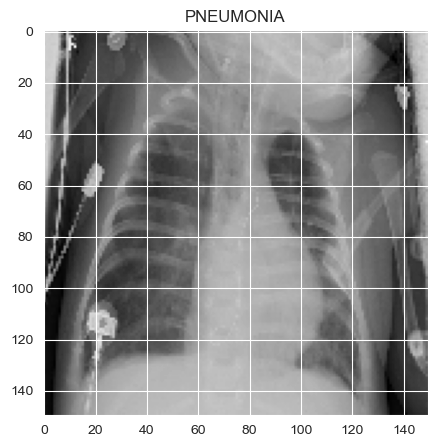

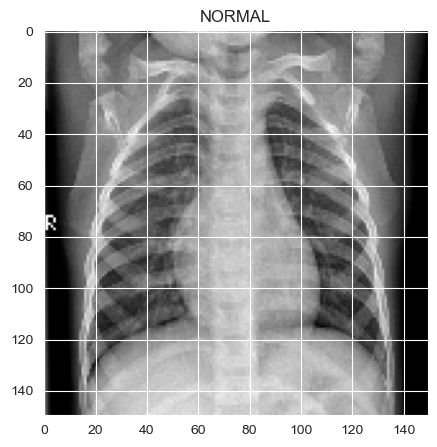

In [11]:
plt.figure(figsize= (5,5))
plt.imshow(train[0][0], cmap="gray")
plt.title(labels[train[1][0]])


plt.figure(figsize= (5,5))
plt.imshow(train[0][-1], cmap="gray")
plt.title(labels[train[1][-1]])

### We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover, the CNN converges faster on [0..1] data than on [0...255]

In [12]:
print(train[1])
print(test[1])
print(val[1])

[0 0 0 ... 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 

In [13]:
# Splitting the train, test and val data into features and labels.
x_train = train[0]
y_train = train[1]

x_val = val[0]
y_val = val[1]

x_test = test[0]
y_test = test[1]


In [14]:
# Normaliza the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255

# (Already resized the data for deep learning the in the function get_training_data)

In [15]:
# try to resize data to mauybe get better output.
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

### Data Augmentation

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [17]:
datagen.fit(x_train)

### Training the Model

In [18]:
import optuna
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.losses import BinaryCrossentropy

### Trying to find the optimized hyperparameters for the model using optune (Bayesian Optimization)

In [20]:
def objective(trial):
    # Suggest hyperparams
    filters1 = trial.suggest_categorical('filters1', [32, 64])
    filters2 = trial.suggest_categorical('filters2', [64, 128])
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.5)
    dense_units = trial.suggest_int('dense_units', 64, 256)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    optimizer_choice = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    # Build model
    model = Sequential()
    model.add(Conv2D(filters1, (3,3), activation='relu', input_shape=(150,150,1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), padding='same'))
    
    model.add(Conv2D(filters2, (3,3), activation='relu', padding='same'))
    model.add(Dropout(dropout1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), padding='same'))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout1))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) if optimizer_choice == 'adam' else tf.keras.optimizers.RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=32, verbose=0)

    return 1.0 - max(history.history['val_accuracy'])



In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2025-03-27 13:24:17,839] A new study created in memory with name: no-name-9843b7be-cfbd-4747-bb68-423c681f1075
/var/folders/bt/y4y1_vy108q8105yqndh1pbm0000gn/T/ipykernel_37554/3499154020.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-03-27 13:32:33,966] Trial 0 finished with value: 0.5 and parameters: {'filters1': 64, 'filters2': 128, 'dropout1': 0.42970449381028547, 'dense_units': 203, 'lr': 0.006322890481224206, 'optimizer': 'adam'}. Best is trial 0 with value: 0.5.
[I 2025-03-27 13:38:09,627] Trial 1 finished with value: 0.5 and parameters: {'filters1': 32, 'filters2': 128, 'dropout1': 0.4688435888944917, 'dense_units': 209, 'lr': 0.0006516985478826631, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.5.
[I 2025-03-27 13:46:50,406] Trial 2 finished with va

In [23]:
from optuna.integration import KerasPruningCallback
from tqdm import tqdm

In [24]:
def objective2(trial):
    # Suggest hyperparams
    filters1 = trial.suggest_categorical('filters1', [32, 64])
    filters2 = trial.suggest_categorical('filters2', [64, 128])
    filters3 = trial.suggest_categorical('filters3', [128, 256])
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.5)
    dense_units = trial.suggest_int('dense_units', 64, 256)
    lr = trial.suggest_loguniform('lr', 0.000001, 0.001)

    # Build model
    model = Sequential()
    model.add(Conv2D(filters1 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(filters2 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(dropout1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(filters2 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(filters3, (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(dropout1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(dropout1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units = dense_units , activation = 'relu'))
    model.add(Dropout(dropout1))
    model.add(Dense(units = 1 , activation = 'sigmoid'))

    # Optimizer rmsprop.
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train plus adding a callback when a model is performing badly to immediately stop.
    pruning_callback = KerasPruningCallback(trial, "val_accuracy")
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=32, verbose=0, callbacks = [pruning_callback])


    return 1.0 - max(history.history['val_accuracy'])

In [25]:
n_trials = 15
study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc="Optimizing Trials"):
    study.optimize(objective2, n_trials=1, catch=(Exception,))

[I 2025-03-27 15:39:02,241] A new study created in memory with name: no-name-ae09ef28-a653-448d-9c6a-760da633b31e
Optimizing Trials:   0%|          | 0/15 [00:00<?, ?it/s]/var/folders/bt/y4y1_vy108q8105yqndh1pbm0000gn/T/ipykernel_37554/769289809.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 0.000001, 0.001)
[I 2025-03-27 15:47:54,392] Trial 0 finished with value: 0.5 and parameters: {'filters1': 32, 'filters2': 128, 'filters3': 256, 'dropout1': 0.1788881291563844, 'dense_units': 89, 'lr': 0.00014992960301711918}. Best is trial 0 with value: 0.5.
Optimizing Trials:  93%|█████████▎| 14/15 [3:09:19<11:23, 683.01s/it]

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# DIT IS AL GERUND, DOE HET NIET OPNIEUW TENZIJ JE KOSTBARE TIJD WILT VERSPILLN

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 48s 290ms/step - loss: 0.5608 - accuracy: 0.8257 - val_loss: 33.7076 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 47s 289ms/step - loss: 0.2903 - accuracy: 0.8878 - val_loss: 24.0961 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.9036
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 47s 288ms/step - loss: 0.2915 - accuracy: 0.9036 - val_loss: 26.9331 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 48s 291ms/step - loss: 0.1665 - accuracy: 0.9365 - val_loss: 144.9416 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9471
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [=================

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 66ms/step - loss: 0.8700 - accuracy: 0.8862
Loss of the model is -  0.8699564933776855
20/20 [==============================] - 1s 64ms/step - loss: 0.8700 - accuracy: 0.8862
Accuracy of the model is -  88.62179517745972 %


### Analysis after model training

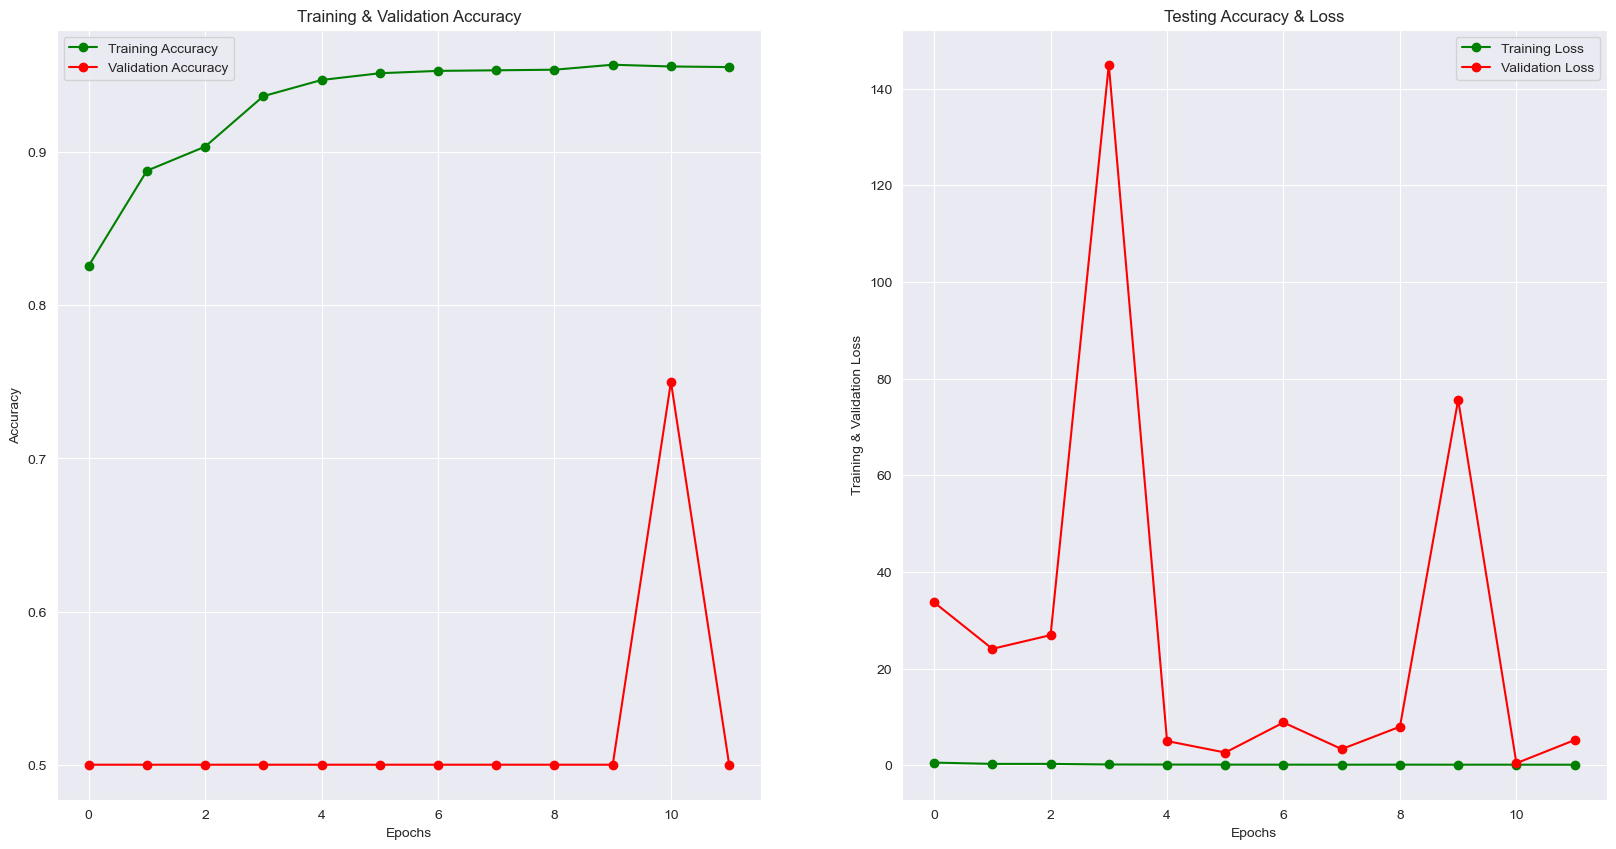

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
# predictions = model.predict_classes(x_test)
predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

20/20 [==============================] - 1s 64ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.87      0.96      0.91       390
   Normal (Class 1)       0.92      0.76      0.83       234

           accuracy                           0.89       624
          macro avg       0.89      0.86      0.87       624
       weighted avg       0.89      0.89      0.88       624



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[374,  16],
       [ 55, 179]])

### Deze stuk hoeft aleen als er sns.heatmap gebruiken, maar dat zorgde dat niet alle cijfers zichtbaar waren dus heb CunfusionMatrixDisplay gebruikt.

In [ ]:
# cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Figure size 1000x1000 with 0 Axes>

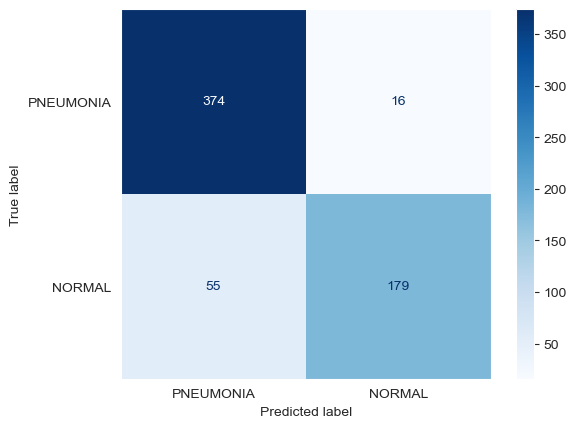

In [ ]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', colorbar=True)
plt.grid(False)


In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

### Some correctly predicted classes

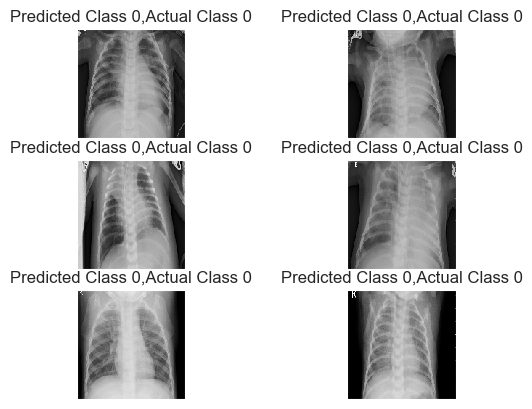

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1

### Some incorrectly predicted classes

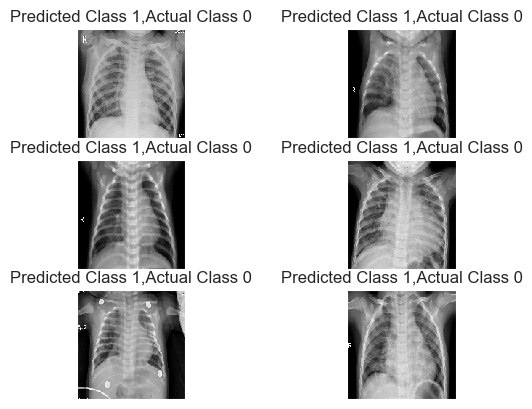

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1

# From here on are the tries to make the model better